### **3. Regularization Lasso CV**
- **Author**  : Sumashree Javaji
- **Dataset** : Melbourne_housing.csv | Melbourne housing
- **Dataset Description** : Melbourne real estate
- **Problem Statement** : The goal is to predict price of house in Melbourne.

### **Data Exploration and Visualization**
- Import data to a pandas dataframe
- Import necessary packages - Pandas , os
- Get high level overview of the data
- Check for null values & proceed with handling na's
- drop unecessary columns (columns with no data - eg. 'unnamed' column or irrelavant data - eg. 'id' column)
- Plot graphs to undertsand the distribution & relation between variables

#### Importing necessary libraries 

In [37]:
### for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

import os

In [38]:
# os.chdir('') # setting cwd to a new path
# os.getcwd() # checking my environment's current working directory

# Loading the data
housing_df_raw = pd.read_csv("Melbourne_housing.csv")
housing_df_raw.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Thornbury,7/67 Pender St,2,u,438000.0,SP,Love,22/08/2016,6.5,3071,...,1.0,1.0,0.0,66.0,1970.0,Darebin City Council,-37.7541,145.0088,Northern Metropolitan,8870
1,Coburg,32 Rose St,2,h,901000.0,S,Peter,27/06/2016,7.8,3058,...,1.0,1.0,545.0,107.0,1940.0,Darebin City Council,-37.7445,144.9471,Northern Metropolitan,11204
2,Bentleigh East,2/25 Brooks St,3,u,800000.0,S,Woodards,28/05/2016,13.9,3165,...,2.0,2.0,261.0,NaN,NaN,Glen Eira City Council,-37.9163,145.0779,Southern Metropolitan,10969
3,Templestowe Lower,2/35 John St,3,t,1155000.0,S,Jellis,25/11/2017,12.4,3107,...,NaN,NaN,NaN,NaN,NaN,Manningham City Council,NaN,NaN,Eastern Metropolitan,5420
4,South Yarra,1/35 Marne St,3,u,1630000.0,PI,Jellis,10/9/2016,3.3,3141,...,1.0,1.0,0.0,NaN,NaN,Melbourne City Council,-37.8359,144.9839,Southern Metropolitan,14887


#### **Observations**
- `Data` : 499 rows & 21 columns
- `Missing values` in the columns -  BuildingArea , YearBuilt , Landsize , Car , Bedroom2 , Bathroom , Longtitude , Lattitude , Price
- `Categorical Data` type Columns(8):  Suburb , Address , Type , Method , SellerG , Date , CouncilArea , Regionname
- `Unique Values`
    - Type : 'u' , 'h' , 't'
    - Regionname : 8
    - Suburb : 184

In [39]:
print('There are',housing_df_raw.shape[0],'rows &',housing_df_raw.shape[1],'columns in the dataset')

There are 499 rows & 21 columns in the dataset


In [40]:
housing_df_raw.info() # To check Data types of each column , memory consumption of the dataset & count of non null records 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         499 non-null    object 
 1   Address        499 non-null    object 
 2   Rooms          499 non-null    int64  
 3   Type           499 non-null    object 
 4   Price          391 non-null    float64
 5   Method         499 non-null    object 
 6   SellerG        499 non-null    object 
 7   Date           499 non-null    object 
 8   Distance       499 non-null    float64
 9   Postcode       499 non-null    int64  
 10  Bedroom2       371 non-null    float64
 11  Bathroom       371 non-null    float64
 12  Car            362 non-null    float64
 13  Landsize       325 non-null    float64
 14  BuildingArea   189 non-null    float64
 15  YearBuilt      212 non-null    float64
 16  CouncilArea    499 non-null    object 
 17  Lattitude      377 non-null    float64
 18  Longtitude

In [41]:
# Checking for the null values in all the columns and printing only the columns with nulls ordered by desc null count 
null_info = pd.DataFrame({'Column': housing_df_raw.isnull().sum().index, 'Null Count': housing_df_raw.isnull().sum().values}).sort_values(by='Null Count' , ascending=False)
null_info['Null Percentage'] = round((null_info['Null Count'] / len(housing_df_raw)) * 100 , 2)
print(null_info[null_info['Null Count'] > 0])

          Column  Null Count  Null Percentage
14  BuildingArea         310            62.12
15     YearBuilt         287            57.52
13      Landsize         174            34.87
12           Car         137            27.45
10      Bedroom2         128            25.65
11      Bathroom         128            25.65
18    Longtitude         122            24.45
17     Lattitude         122            24.45
4          Price         108            21.64


#### **Handling Missing Data**

- Since we will be training the model on predicting price, it would make sense to drop any null values in the price column
- Since car, latitude & longitude are not key columns, imputing NA's with 0 to differentiate these records from the other records in the dataset
- Imputing with Mean : buildng area , land size
- Imputing with Median : bathroom , bedroom & YearBuilt
- New Dataset has 391 record since we dropped the 108 NA's in Price column
- One-hot encoding : applying encoding on Regionname & Type columns

In [42]:
# Copying the housing data to a new dataframe to store a copy of original raw data
housing_df = housing_df_raw.copy()

# dropping missing columns in price 
housing_df.dropna(subset=['Price'], inplace=True)

# filling with 0
columns_to_impute = ['Car' , 'Longtitude' , 'Lattitude' ]
housing_df[columns_to_impute] = housing_df[columns_to_impute].fillna(0) 

# Finding the mean of the column having NaN
BuildingArea_mean = housing_df['BuildingArea'].mean()
Landsize_mean     = housing_df['Landsize'].mean()
Bedroom2_median = housing_df['Bedroom2'].median()
Bathroom_median = housing_df['Bathroom'].median()
YearBuilt_median = housing_df['YearBuilt'].median()

# Replace NaNs in BuildingArea with the mean of values in BuildingArea
housing_df['BuildingArea'].fillna(value=BuildingArea_mean, inplace=True)
housing_df['Landsize'].fillna(value=Landsize_mean, inplace=True)
housing_df['Bedroom2'].fillna(value=Bedroom2_median, inplace=True)
housing_df['Bathroom'].fillna(value=Bathroom_median, inplace=True)
housing_df['YearBuilt'].fillna(value=YearBuilt_median, inplace=True)

housing_df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Thornbury,7/67 Pender St,2,u,438000.0,SP,Love,22/08/2016,6.5,3071,...,1.0,1.0,0.000000,66.000000,1970.0,Darebin City Council,-37.75410,145.00880,Northern Metropolitan,8870
1,Coburg,32 Rose St,2,h,901000.0,S,Peter,27/06/2016,7.8,3058,...,1.0,1.0,545.000000,107.000000,1940.0,Darebin City Council,-37.74450,144.94710,Northern Metropolitan,11204
2,Bentleigh East,2/25 Brooks St,3,u,800000.0,S,Woodards,28/05/2016,13.9,3165,...,2.0,2.0,261.000000,144.172785,1970.0,Glen Eira City Council,-37.91630,145.07790,Southern Metropolitan,10969
3,Templestowe Lower,2/35 John St,3,t,1155000.0,S,Jellis,25/11/2017,12.4,3107,...,1.0,0.0,525.146067,144.172785,1970.0,Manningham City Council,0.00000,0.00000,Eastern Metropolitan,5420
4,South Yarra,1/35 Marne St,3,u,1630000.0,PI,Jellis,10/9/2016,3.3,3141,...,1.0,1.0,0.000000,144.172785,1970.0,Melbourne City Council,-37.83590,144.98390,Southern Metropolitan,14887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,Fawkner,8 Baird St,2,h,761000.0,S,Ray,24/06/2017,13.1,3060,...,1.0,2.0,665.000000,30.000000,1970.0,Hume City Council,-37.70673,144.97108,Northern Metropolitan,5070
494,Sunshine,74 Hertford Rd,2,h,965000.0,S,Barry,26/08/2017,10.5,3020,...,1.0,1.0,525.146067,144.172785,1970.0,Brimbank City Council,-37.78227,144.84038,Western Metropolitan,3755
495,Springvale,15 Phillip Av,3,h,721000.0,S,Hall,24/06/2017,20.8,3171,...,1.0,0.0,525.146067,144.172785,1970.0,Greater Dandenong City Council,0.00000,0.00000,South-Eastern Metropolitan,7412
496,Middle Park,150 Page St,3,h,1750000.0,VB,Greg,27/05/2017,3.0,3206,...,2.0,0.0,138.000000,155.000000,1885.0,Port Phillip City Council,-37.84962,144.95856,Southern Metropolitan,2019


In [43]:
# Checking missing values post imputation/handling
null_info = pd.DataFrame({'Column': housing_df.isnull().sum().index, 'Null Count': housing_df.isnull().sum().values}).sort_values(by='Null Count' , ascending=False)
print(null_info[null_info['Null Count'] > 0])

Empty DataFrame
Columns: [Column, Null Count]
Index: []


In [44]:
unique_region = housing_df_raw['Regionname'].unique()
unique_region_count =  housing_df_raw['Regionname'].nunique()

unique_type = housing_df_raw['Type'].unique()
unique_type_count =  housing_df_raw['Type'].nunique()

unique_suburb_count =  housing_df_raw['Suburb'].nunique()

print("Unique # of regions :"+ str(unique_region_count))
print('Regions in dataset :\n',unique_region)

print('\nType in dataset :',unique_type)
print("unique type :"+ str(unique_type_count))

print("\nUnique # of Suburbs :"+ str(unique_suburb_count))

Unique # of regions :8
Regions in dataset :
 ['Northern Metropolitan' 'Southern Metropolitan' 'Eastern Metropolitan'
 'Western Metropolitan' 'South-Eastern Metropolitan' 'Eastern Victoria'
 'Western Victoria' 'Northern Victoria']

Type in dataset : ['u' 'h' 't']
unique type :3

Unique # of Suburbs :184


#### **Bar Chart - House types**
To check the distribution/Volume of the type of houses
- Type :
    1. h : house,cottage,villa, semi,terrace;  **65.93%**
    2. u - unit, duplex; **22.44%**
    3. t - townhouse; **11.62%**

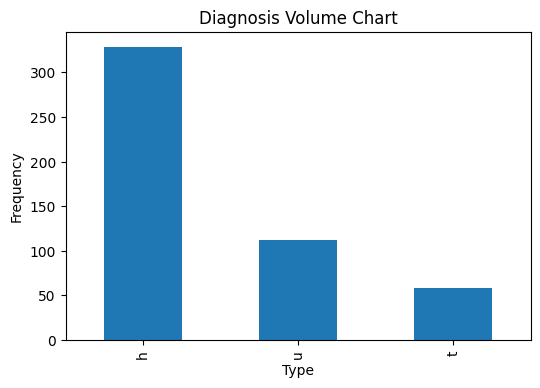

In [45]:
count = housing_df_raw['Type'].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Diagnosis Volume Chart")
count.set_xlabel("Type")
count.set_ylabel("Frequency")

plt.show()

In [46]:
round((housing_df_raw['Type'].value_counts()/len(housing_df_raw)*100),2)

Type
h    65.93
u    22.44
t    11.62
Name: count, dtype: float64

#### **BoxPlots - BuildingArea**
Median from the box plot suggests that the data is right skewed, which means that though there are lot of building areas around 120, there are a few large building areas which are contributing to the skewness

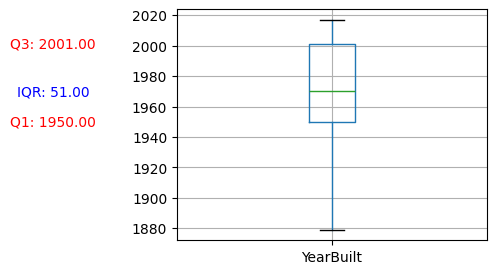

In [47]:

# Boxplot for Earnings Per Share of all the filings
plt.figure(figsize=(4,3))
housing_df_raw.boxplot(column='YearBuilt')

# Calculate IQR
q1 = np.percentile(housing_df_raw['YearBuilt'].dropna(), 25)
q3 = np.percentile(housing_df_raw['YearBuilt'].dropna(), 75)
iqr = q3 - q1

# displaying the IQR on the graph
plt.text(0.1, q1, f'Q1: {q1:.2f}', horizontalalignment='center', verticalalignment='center', color='red')
plt.text(0.1,  q3, f'Q3: {q3:.2f}', horizontalalignment='center', verticalalignment='center', color='red')
plt.text(0.1,  q1+20, f'IQR: {iqr:.2f}', horizontalalignment='center', verticalalignment='center', color='blue')

# Show the plot
plt.show()

<Figure size 600x400 with 0 Axes>

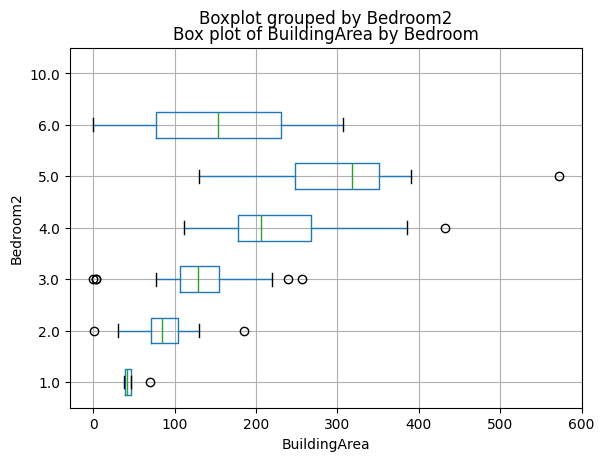

In [48]:
plt.figure(figsize=(6, 4))
housing_df_raw.boxplot(column='BuildingArea', by='Bedroom2', vert=False)
plt.title("Box plot of BuildingArea by Bedroom")
plt.xlabel("BuildingArea")
plt.ylabel("Bedroom2")
plt.show()

#### Price distribution across various regions
southern metropolitan has the highest price; with Eastern metropolitan being the 2nd highest

<Figure size 1000x500 with 0 Axes>

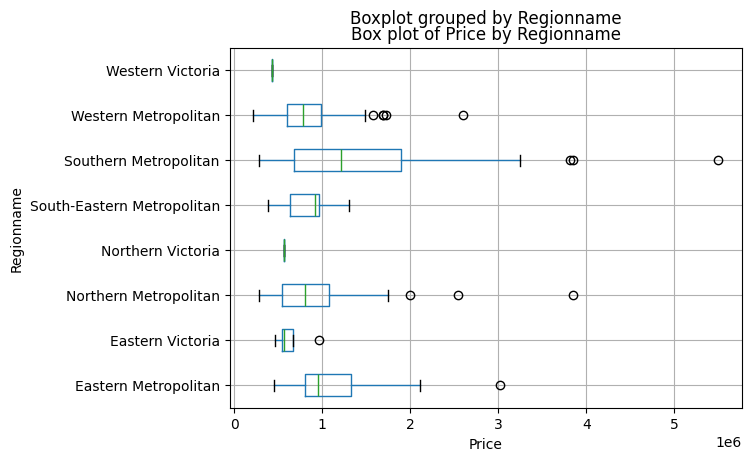

In [49]:
plt.figure(figsize=(10, 5))
housing_df_raw.boxplot(column='Price', by='Regionname', vert=False)
plt.title("Box plot of Price by Regionname")
plt.xlabel("Price")
plt.ylabel("Regionname")
plt.show()

#### **Price vs Number of Bedrooms**
There is an increasing trend in the price with the number of bedrooms

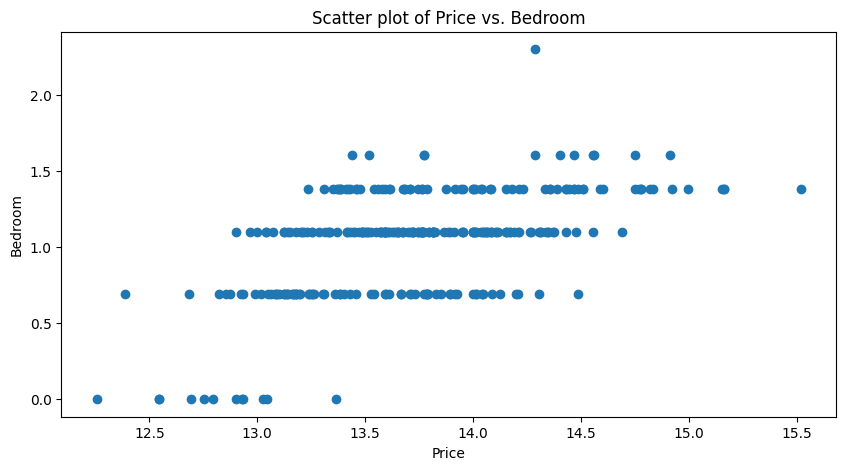

In [50]:
# Scatter plot for miles vs. price
plt.figure(figsize=(10, 5))
plt.scatter(np.log(housing_df_raw['Price']), np.log(housing_df_raw['Bedroom2'])) # Applying logto standardise the results on both x & y scales and get a better picture of the data
plt.title("Scatter plot of Price vs. Bedroom")
plt.xlabel("Price")
plt.ylabel("Bedroom")
plt.show()

#### **Correlation Matrix - all variables(X) with diagnosis (Y)**
- Building Area, Number of Bathrooms , Number of bedrooms & total number of rooms are highly correlated with the price of the house (positive correlation)
- year built & distance are negatively correlated to the price of the houses
  - price decreases with the age of the house
  - price decreases with the distance away from the central business district which is located in the center of the city. as as the property moves away from the center, the price decreases

In [51]:
# Automating the correlation matrix , requires the df to have just the continuous columns. 
# Filtering just for the numeric datatypes and storing them in a new df
continuous_columns = housing_df_raw.select_dtypes(include=['float64', 'int64']).columns
housing_df_raw_continuous = housing_df_raw[continuous_columns]
housing_df_raw_continuous=housing_df_raw_continuous.drop(columns=['Price'])

Text(0.5, 1.0, 'Correlation w.r.t Price')

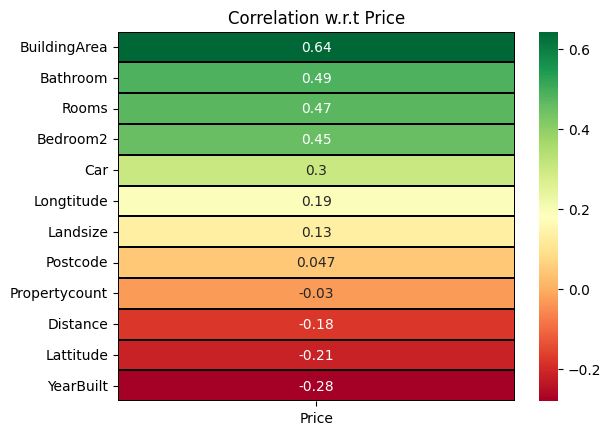

In [52]:
## Calculating & conditional formating the correlation between all the continuous variables of the dataset vs diagnosis
corr = housing_df_raw_continuous.corrwith(housing_df_raw['Price']).sort_values(ascending = False).to_frame() 
corr.columns = ['Price']
sns.heatmap(corr,annot = True,cmap = 'RdYlGn',linewidths = 0.3,linecolor = 'black');
plt.title('Correlation w.r.t Price')


#### **Price of various House Types**
- All the unit/duplex houses are less than 0.75M
- 3/4bhk's in h (cottage,villa, semi,terrace) type are expensive compared to the ones in t (townhouse) type

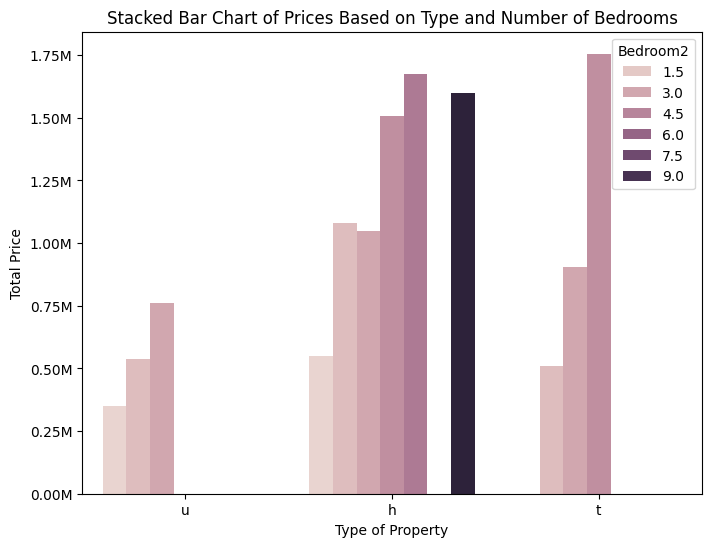

In [53]:
import seaborn as sns
from matplotlib.ticker import FuncFormatter 

# Create a stacked bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Type', y='Price', hue='Bedroom2', data=housing_df_raw, estimator='mean', errorbar=None)

# Add labels and title
plt.xlabel('Type of Property')
plt.ylabel('Total Price')
plt.title('Stacked Bar Chart of Prices Based on Type and Number of Bedrooms')

# Format Price labels to display in millions
def format_millions(value, _):
    return f'{value / 1e6:.2f}M'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_millions))
plt.show()


### **Linear Regression Model Development** :
- one hot encoded regionname & type columns

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # to divide the data into training & validation 

In [55]:
# One-hot encoding
housing_df_encoded = pd.get_dummies(housing_df, columns=['Regionname','Type'], drop_first=True)

# converting the encoded variables to integer type, by default they are of bool type
housing_df_encoded[['Type_t' ,'Type_u' ,'Regionname_Eastern Victoria' ,'Regionname_Northern Metropolitan' ,'Regionname_Northern Victoria' ,'Regionname_South-Eastern Metropolitan' ,'Regionname_Southern Metropolitan' ,'Regionname_Western Metropolitan' ,'Regionname_Western Victoria']] = housing_df_encoded[['Type_t' ,'Type_u' ,'Regionname_Eastern Victoria' ,'Regionname_Northern Metropolitan' ,'Regionname_Northern Victoria' ,'Regionname_South-Eastern Metropolitan' ,'Regionname_Southern Metropolitan' ,'Regionname_Western Metropolitan' ,'Regionname_Western Victoria']].astype(int)
housing_df_encoded.head()


,Suburb,Address,Rooms,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,...,Propertycount,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,Type_t,Type_u
0,Thornbury,7/67 Pender St,2,438000.0,SP,Love,22/08/2016,6.5,3071,2.0,...,8870,0,1,0,0,0,0,0,0,1
1,Coburg,32 Rose St,2,901000.0,S,Peter,27/06/2016,7.8,3058,2.0,...,11204,0,1,0,0,0,0,0,0,0
2,Bentleigh East,2/25 Brooks St,3,800000.0,S,Woodards,28/05/2016,13.9,3165,3.0,...,10969,0,0,0,0,1,0,0,0,1
3,Templestowe Lower,2/35 John St,3,1155000.0,S,Jellis,25/11/2017,12.4,3107,3.0,...,5420,0,0,0,0,0,0,0,1,0
4,South Yarra,1/35 Marne St,3,1630000.0,PI,Jellis,10/9/2016,3.3,3141,3.0,...,14887,0,0,0,0,1,0,0,0,1


In [56]:
housing_df_input = housing_df_encoded.copy()
continuous_columns_ip = housing_df_input.select_dtypes(include=['float64', 'int64']).columns
housing_df_input_continuous = housing_df_input[continuous_columns_ip]

#### **Implementing forward selection algorithm for feature selection on cleaned & transformed data**
- Feature selection is done by selecting the model with minimum rmse on test data
- Filtered the independent variables(X) by selecting the columns produced by forward selection algorithm
- Trained the linear regression on training data
- Predicted the housing Prices on test data
- Compared the validation data predicted vs Actual to calculate MSE & OOS R2

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

target_column = 'Price'

# Create empty lists to store selected features and corresponding MSE
selected_features = []
mse_values = []

# Split the data into features (X) and target variable (y)
X = housing_df_input_continuous.drop(target_column, axis=1)
y = housing_df_input_continuous[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression model
model = LinearRegression()

# Forward Selection Process
for feature in X.columns:
    # Add one feature at a time to the selected features
    selected_features.append(feature)
    
    # Fit the model with the selected features
    model.fit(X_train[selected_features], y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test[selected_features])
    
    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Find the index of the minimum MSE value
best_feature_index = mse_values.index(min(mse_values))

# Print the selected features and corresponding MSE values
print("Selected Features: \n", selected_features[:best_feature_index + 1])
print("Corresponding MSE Values:\n", mse_values[:best_feature_index + 1])


Selected Features: 
 ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'Regionname_Eastern Victoria', 'Regionname_Northern Metropolitan', 'Regionname_Northern Victoria', 'Regionname_South-Eastern Metropolitan', 'Regionname_Southern Metropolitan', 'Regionname_Western Metropolitan', 'Regionname_Western Victoria', 'Type_t', 'Type_u']
Corresponding MSE Values:
 [603009115408.4219, 540593140827.0535, 499144032884.084, 493793199015.6465, 462189581570.4636, 463894994522.80273, 461552958389.63947, 456951269477.67206, 441061690566.2871, 443309975075.0524, 419033149784.43164, 419779233787.0926, 418931109847.931, 414890836081.5141, 414761983309.0203, 416782956156.8468, 408166238200.756, 403279182996.41473, 403138385855.61115, 403352310264.35425, 368152362243.1973]


In [58]:
# Stroing all the independent variables in X & dependent variable in y
# model has suggested that car is a significant variable in predicting the prices, but we know that theoretically it does not make sense, so I will not be including car column in m model
selected_columns = ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'Regionname_Eastern Victoria', 'Regionname_Northern Metropolitan', 'Regionname_Northern Victoria', 'Regionname_South-Eastern Metropolitan', 'Regionname_Southern Metropolitan', 'Regionname_Western Metropolitan', 'Regionname_Western Victoria', 'Type_t', 'Type_u']

X = housing_df_input_continuous[selected_columns]
y = housing_df_input_continuous.loc[:, housing_df_input_continuous.columns == 'Price']


In [59]:
## Checking multicollinearity on selected columns (X variables)
# we can ignore the VIF on intercept column, VIF of all other columns is low implying no/low multi collinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


                                 Variable            VIF
0                                   Rooms      38.619131
1                                Distance       8.715346
2                                Postcode    1700.975839
3                                Bedroom2      47.407916
4                                Bathroom      11.669845
5                                     Car       4.919344
6                                Landsize       1.869280
7                            BuildingArea      13.355085
8                               YearBuilt    1697.552701
9                               Lattitude  429579.230262
10                             Longtitude  429645.210820
11                          Propertycount       4.364472
12            Regionname_Eastern Victoria       1.902301
13       Regionname_Northern Metropolitan       4.134456
14           Regionname_Northern Victoria       1.308012
15  Regionname_South-Eastern Metropolitan       1.760033
16       Regionname_Southern Me

In [60]:
# import statsmodels.api as sm
X=sm.add_constant(X)
results=sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     28.56
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           1.89e-64
Time:                        14:26:24   Log-Likelihood:                -5589.6
No. Observations:                 391   AIC:                         1.122e+04
Df Residuals:                     369   BIC:                         1.131e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                  6.864e+06   2.17e+06      3.170      0.002    2.61e+06    1.11e+07
Rooms                                  1.996e+05   4.08e+04      4.888      0.000    1.19e+05     2.8e+05
Distance                              -4.449e+04   4979.867     -8.934      0.000   -5.43e+04   -3.47e+04
Postcode                                629.5344    301.286      2.089      0.037      37.082    1221.987
Bedroom2                              -6.416e+04    4.5e+04     -1.426      0.155   -1.53e+05    2.43e+04
Bathroom                               2.071e+05    4.3e+04      4.815      0.000    1.23e+05    2.92e+05
Car                                    6.996e+04   2.63e+04      2.665      0.008    1.83e+04    1.22e+05
Landsize                                 52.0927     34.855      1.495      0.136     -16.446     120.632
BuildingArea                           1812.8047    490.076      3.699      0.000     849.112    2776.497
YearBuilt                             -4091.4821    998.175     -4.099      0.000   -6054.306   -2128.658
Lattitude                             -6.309e+05   4.04e+05     -1.560      0.120   -1.43e+06    1.64e+05
Longtitude                            -1.657e+05   1.05e+05     -1.571      0.117   -3.73e+05    4.16e+04
Propertycount                             4.1061      5.019      0.818      0.414      -5.763      13.975
Regionname_Eastern Victoria            1.389e+05   2.81e+05      0.495      0.621   -4.13e+05    6.91e+05
Regionname_Northern Metropolitan      -2.462e+05   7.57e+04     -3.250      0.001   -3.95e+05   -9.72e+04
Regionname_Northern Victoria           3.679e+05   4.61e+05      0.799      0.425   -5.38e+05    1.27e+06
Regionname_South-Eastern Metropolitan  9.905e+04   1.43e+05      0.694      0.488   -1.82e+05     3.8e+05
Regionname_Southern Metropolitan       1.564e+05    8.5e+04      1.839      0.067   -1.08e+04    3.24e+05
Regionname_Western Metropolitan       -2.772e+05   7.91e+04     -3.505      0.001   -4.33e+05   -1.22e+05
Regionname_Western Victoria           -1.513e+05   4.18e+05     -0.362      0.718   -9.73e+05     6.7e+05
Type_t                                -1.551e+05   7.36e+04     -2.108      0.036      -3e+05   -1.04e+04
Type_u                                -4.387e+05   6.72e+04     -6.526      0.000   -5.71e+05   -3.06e+05
==============================================================================
Omnibus:                      258.940   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4034.147
Skew:                           2.553   Prob(JB):                         0.00
Kurtosis:                      17.885   Cond. No.                     9.67e+05
======================================

### **Model Evaluation**
- OOS R2 : 0.504 - The model is able to explain the 50% of the variation in the prices of the houses
- OOS MSE : 361.49 billion - MSE is very high and the model is not able to explain the variability in the data well
- which implies that we should further work on enhancing the model's accuracy

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

selected_columns = ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'Regionname_Eastern Victoria', 'Regionname_Northern Metropolitan', 'Regionname_Northern Victoria', 'Regionname_South-Eastern Metropolitan', 'Regionname_Southern Metropolitan', 'Regionname_Western Metropolitan', 'Regionname_Western Victoria', 'Type_t', 'Type_u']

X = X_train[selected_columns]
y = y_train

# Initialize and fit the model
model = LinearRegression()
model.fit(X, y)

linear_preds=model.predict(X_test[selected_columns].values)
linear_model_mse = mean_squared_error(y_test,linear_preds)
linear_model_r2 = r2_score(y_test, linear_preds)

print("OOS MSE:", linear_model_mse)
print("OOS R^2:", linear_model_r2)

OOS MSE: 368152362243.1973
OOS R^2: 0.49521238094849174


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


#### **Regularization - Lasso**
- Why are we using Lasso regularization
- Evaluation of linear regression model implies that it's explaining only 50% of variation in price, We could further improve the models predictability by using lasso regression to select significant features.
    - Regularisation : is making changes to our model (regression in our case) with an intention to lower the generalization error but not the training error
    - We should aim
        - to significantly decrease variability while not adding a lot of bias to our training data
        - Go from overfitting model to a balanced model which has both low bias & variability
    - To implement regularization, we introduce a cost penalty factor or hyperparameter lambda/alpha to our model
    - Lasso penalizes a model based on the sum of the absolute coefficient values

**Steps :**
- Standardize X variables: Lasso performs best when all numerical features are centered around 0. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. This means it is important to standardize features. We do this by using StandardScaler library
- Cross-validation: is used to find optimal alpha that balances model complexity and predictive performance on new data. (alpha obtained from CV = 2154.43 in this case) using library sklearn.linear_model (lasso)
- Train & Test Models using alpha = 2154.43 and compare the In sample & OOS , Rsquare & MSE 
- Analyze and compare the results
    - OOS results for Linear Regression & Lasso do not have any significant differences; Linear Regression R2 = 0.495 | Lasso R2 = 0.489
    - This could be happening due to Small Dataset : I believe that the housing dataset is too small due to which the model is unable to generalize well to test data as it has less information (i.e. there isn't lot of diversity in X variables for the model to generalise) & it's performance is sensitive to the variability in the dataset. Therefore, the chnages in alpha value are still resulting in unreliable performance metrics

In [62]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.preprocessing import StandardScaler

In [63]:
alphas = np.logspace(-6, 6, 10)
k = 5
n = len(y_train)

# Shuffle the data
indices = np.arange(n)
np.random.shuffle(indices)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_2 = y_train
y_test_2 = y_test

X_cv = X_train_scaled[indices]
y_cv = y_train.iloc[indices]
X_train_scaled.shape

(312, 21)

In [64]:
# Use cross-validation to find an optimal regularization strength (alpha) that balances model complexity and predictive performance on new data.
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) # to ignore printing the warnings to the screen

avg_rmse=[]

for alpha in alphas:
    rmse_list = []

    # Manual k-fold splitting
    for fold in range(k):
        # Calculate the size of each fold
        fold_size = n // k
        
        # Define the start and end indices of the test set
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))
    
# Find the best alpha
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

Best alpha: 2154.434690031878


#### **Fitting the Linear regression with Lasso** (alpha = 2154 ; obtained from the CV Lasso performed above)
- In Sample Rsqaure is 66%
- OOS Rsquare = 48.9%
- Model performing well on training dataset but not able to generalise well on validation set indicates overfitting 

In [65]:
lasso_cv = Lasso(alpha=2154)
lasso_cv.fit(X_train_scaled, y_train_2)

# In-sample performance
pred_y = lasso_cv.predict(X_train_scaled)

mse = mean_squared_error(y_train_2, pred_y)
r2 = r2_score(y_train_2, pred_y)
print("In sample MSE:", mse)
print("In sample R^2:", round(r2,4))

In sample MSE: 104249112936.12575
In sample R^2: 0.6672


In [66]:
# OOS 
y_pred = lasso_cv.predict(X_test_scaled)

print("Lasso coefficients:", lasso_cv.coef_)
print("Intercept:", lasso_cv.intercept_)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_2, y_pred)
r2 = r2_score(y_test_2, y_pred)
print("\nMSE:", mse)
print("R^2:", round(r2,4))

Lasso coefficients: [ 146956.8024348  -273812.42915208   31637.11052916  -31883.9505766
  110325.5740859    99482.19475227   24021.24289483   97687.7122914
 -100159.74045512   11080.12077895  -70721.61021241    9935.42300841
   40402.92061147 -112667.47178978   15732.92796981   38190.12433897
   83004.38291153 -108393.27067707   -2453.74541603  -42745.76822167
 -161347.04550132]
Intercept: 1004231.2499999995

MSE: 372536785452.5371
R^2: 0.4892


### **Out-of-sample performance**
- Split the data into a new training and test 80-20.
- Newly train (fit) the linear regression model on the training data.
- Newly train (fit) the lasso regression model on the training data.
- Estimate AIC, AICc, BIC, as well as 5-fold CV for both models using only the training data.
- Estimate the models true OOS performance by computing their deviance on the test data.
- Compare all (deviance) values.  Which IC is most similar to the models’ true OOS performance?  How does 5-fold CV compare?  Explain.

**Results :** 
- All the performance evaluators are in favour of the linear regression model over the lasso one as the AIC, AICc & BIC are all low for linear model.
- Deviance is low for linear model compared to lasso, and lower the deviance the better the fit of the model on validation set
- 5 fold RMSE - though high for both the models, is slightly lesser for the Lasso model

In [67]:
X_ls = housing_df_input_continuous.drop('Price', axis=1)
y_ls = housing_df_input_continuous['Price']
X_ls = X_ls[selected_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ls, y_ls, test_size=0.2, random_state=38)
linear = sm.OLS(y_train, X_train).fit()

In [68]:
# standardising the X variable values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_2 = Lasso(alpha=2154)
lasso_2.fit(X_train_scaled, y_train)

Lasso(alpha=2154)

In [69]:
# Estimate AIC, AICc, BIC & 5-fold CV for Linear regression model using training data. 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

# AIC
aic = linear.aic

# AICc
n_obs = len(y_train)
n_parameter = linear.df_model + 1
aicc = aic + (2 * n_parameter * (n_parameter+1))/(n_obs - n_parameter - 1)

# BIC
bic = linear.bic

print(f'AIC is {aic}') 
print(f'AICc is {aicc}') 
print(f'BIC is {bic}') 

# 5-fold CV
fold_5 = KFold(n_splits=5, shuffle = True, random_state= 12)
model_MSE = cross_val_score(LinearRegression(), X_train, y_train, cv = fold_5, scoring = make_scorer(mean_squared_error))
model_MSE = np.mean(model_MSE)
print(f'Mean Squared Error for Linear Regression on training data is {model_MSE}.')

AIC is 8978.66394007331
AICc is 8981.85014696986
BIC is 9053.5240038295
Mean Squared Error for Linear Regression on training data is 192685905591.7792.


In [70]:
# Estimate AIC, AICc, BIC & 5-fold CV for Lasso regression model using training data. 
# calculating Aic, Aicc and Bic by using the formulas

# MSE
y_pred = lasso_2.predict(X_train)
sse = np.sum((y_pred - y_train)**2)

# k , n
k = len(lasso_2.coef_) + 1
n = len(y_train)

# AIC
aic_lasso = n * np.log(sse / n) + 2 * k

# AICc
aicc_lasso = aic_lasso + (2 * k * (k + 1)) / (n - k - 1)

# BIC
bic_lasso = n * np.log(sse / n) + k * np.log(n)

print(f'AIC for Lasso model is {aic_lasso}') 
print(f'AICc for Lasso model is {aicc_lasso}') 
print(f'BIC for Lasso model is {bic_lasso}') 

# 5-fold CV
fold_5 = KFold(n_splits=5, shuffle = True, random_state= 12)
model_lasso_MSE = cross_val_score(lasso_2, X_train, y_train, cv = fold_5, scoring = make_scorer(mean_squared_error))
model_lasso_MSE = np.mean(model_lasso_MSE)
print(f'Mean Squared Error for Lasso Regression on training data is {model_lasso_MSE}.')

AIC for Lasso model is 11845.39826368769
AICc for Lasso model is 11848.899993791496
BIC for Lasso model is 11927.744333819499
Mean Squared Error for Lasso Regression on training data is 190758073045.0482.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [71]:
def deviance(y, pred, family="gaussian"):
    if family == "gaussian":
        return np.sum((y - pred) ** 2)
    elif family == "binomial":
        y = np.array(y)
        pred = np.array(pred)
        return -2 * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

In [72]:
# OOS performance 

# linear regression model
y_pred_test_linear = linear.predict(X_test)
linear_model_deviance = deviance(y_test, y_pred_test_linear)

# lasso regression model
y_pred_test_lasso = lasso_2.predict(X_test)
lasso_model_deviance = deviance(y_test, y_pred_test_lasso)

print(f'Test data deviance for Linear regression model is {linear_model_deviance}.')
print(f'Test data deviance for Lasso regression model is {lasso_model_deviance}.')

Test data deviance for Linear regression model is 11411112032023.812.
Test data deviance for Lasso regression model is 1.8157949729074225e+18.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
